# **Importing all necessary libraries**

In [ ]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_cv
import cv2
import random
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend


# **Setting random seed**

In [ ]:
seed=1234
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.experimental.numpy.random.seed(seed)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")
set_seed(seed)

Random seed set as 1234


# **Saving dataset into arrays**

# **For training model was used dataset with cats and dogs: https://www.kaggle.com/datasets/tongpython/cat-and-dog/**

In [ ]:
img_size=64
X=np.zeros(shape=(10028,img_size,img_size,3),dtype='uint8')
y=[]
i=0
for img in os.listdir('/kaggle/input/cat-and-dog/training_set/training_set/dogs/'):
    if img.endswith('.jpg'):
        image=cv2.imread('/kaggle/input/cat-and-dog/training_set/training_set/dogs/'+img)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(img_size,img_size))
        X[i]=image
        y.append(0)
        i+=1
for img in os.listdir('/kaggle/input/cat-and-dog/test_set/test_set/dogs/'):
    if img.endswith('.jpg'):
        image=cv2.imread('/kaggle/input/cat-and-dog/test_set/test_set/dogs/'+img)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(img_size,img_size))
        X[i]=image
        y.append(0)
        i+=1
for img in os.listdir('/kaggle/input/cat-and-dog/training_set/training_set/cats/'):
    if img.endswith('.jpg'):
        image=cv2.imread('/kaggle/input/cat-and-dog/training_set/training_set/cats/'+img)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(img_size,img_size))
        X[i]=image
        y.append(1)
        i+=1
for img in os.listdir('/kaggle/input/cat-and-dog/test_set/test_set/cats/'):
    if img.endswith('.jpg'):
        image=cv2.imread('/kaggle/input/cat-and-dog/test_set/test_set/cats/'+img)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image=cv2.resize(image,(img_size,img_size))
        X[i]=image
        y.append(1)
        i+=1
y=np.array(y)
X,y=shuffle(X,y,random_state=1)
print(X.shape)
print(y.shape)

(10028, 64, 64, 3)
(10028,)


# **Visualizing some images from the dataset**

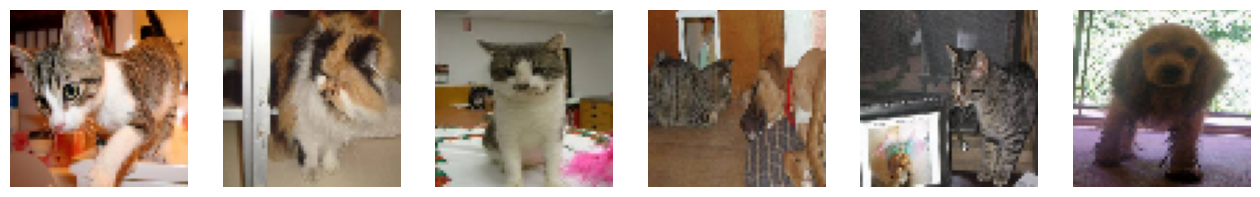

In [ ]:
fig=plt.figure(figsize=(16,16))
for i in range(6):
    ax=fig.add_subplot(1,6,i+1)
    ax.axis('off')
    ax.imshow(X[i])
plt.show()

# **Splittig dataset, and transforming recieved sets to the suitable for TensorFlow format**

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(X,y,random_state=1,train_size=0.75)
X_train_l,X_train_u,y_train_l,y_train_u=train_test_split(X_train,y_train,random_state=1,train_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_train_l.shape)
print(y_train_l.shape)
print(X_train_u.shape)
print(y_train_u.shape)
print(X_val.shape)
print(y_val.shape)

(7521, 64, 64, 3)
(7521,)
(2256, 64, 64, 3)
(2256,)
(5265, 64, 64, 3)
(5265,)
(2507, 64, 64, 3)
(2507,)


In [ ]:
BATCH_SIZE=64
train_data=tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train),tf.convert_to_tensor(y_train))).batch(BATCH_SIZE)
train_labeled_data=tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train_l),tf.convert_to_tensor(y_train_l))).batch(BATCH_SIZE)
train_unlabeled_data=tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_train_u),tf.convert_to_tensor(y_train_u))).batch(BATCH_SIZE)
val_data=tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(X_val),tf.convert_to_tensor(y_val))).batch(BATCH_SIZE)

# **Training model on a complete set**

In [ ]:
EPOCHS=10
base_model=tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
for layers in base_model.layers:
    layers.trainable=False
model=tf.keras.Sequential([base_model,
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(units=2,activation='softmax')])
model.summary()
model.compile(tf.keras.optimizers.Adamax(learning_rate=3e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'],run_eagerly=True)
hist=model.fit(train_data,validation_data=val_data,epochs=EPOCHS)

80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 20028482 (76.40 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
Epoch 1/10
118/118 [==============================] - 18s 102ms/step - loss: 7.0184 - Accuracy: 0.6111 - val_loss: 5.2391 - val_Accuracy: 0.6570
Epoch 2/10
118/118 [==============================] - 12s 100ms/st

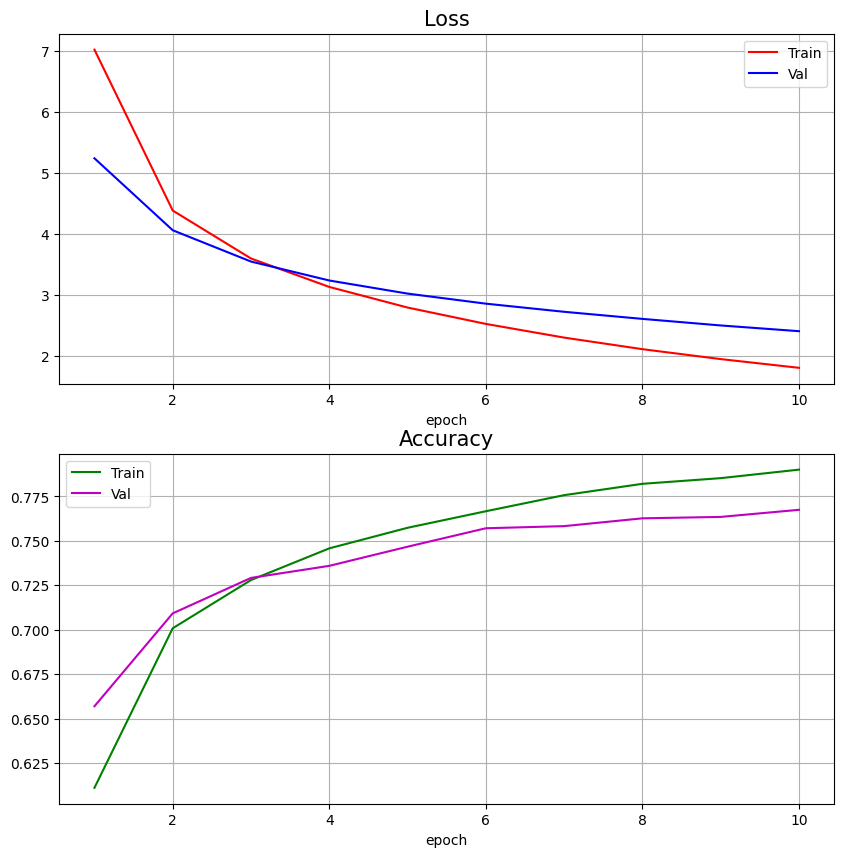

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['Accuracy']
val_acc=hist.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

In [ ]:
model.save_weights('/kaggle/working/weights_1.h5')

# **Training model only on a labeled dataset**

In [ ]:
EPOCHS=20
base_model=tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
for layers in base_model.layers:
    layers.trainable=False
model=tf.keras.Sequential([base_model,
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(units=2,activation='softmax')])
model.summary()
model.compile(tf.keras.optimizers.Adamax(learning_rate=3e-4),loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['Accuracy'],run_eagerly=True)
hist=model.fit(train_labeled_data,validation_data=val_data,epochs=EPOCHS)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 20028482 (76.40 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________
Epoch 1/20
36/36 [==============================] - 5s 126ms/step - loss: 8.4256 - Accuracy: 0.5616 - val_loss: 6.2984 - val_Accuracy: 0.6270
Epoch 2/20
36/36 [==============================] - 4s 125ms/step - loss: 5.4786 - Accuracy: 0.6525 - val_loss: 5.3051 - val_Accurac

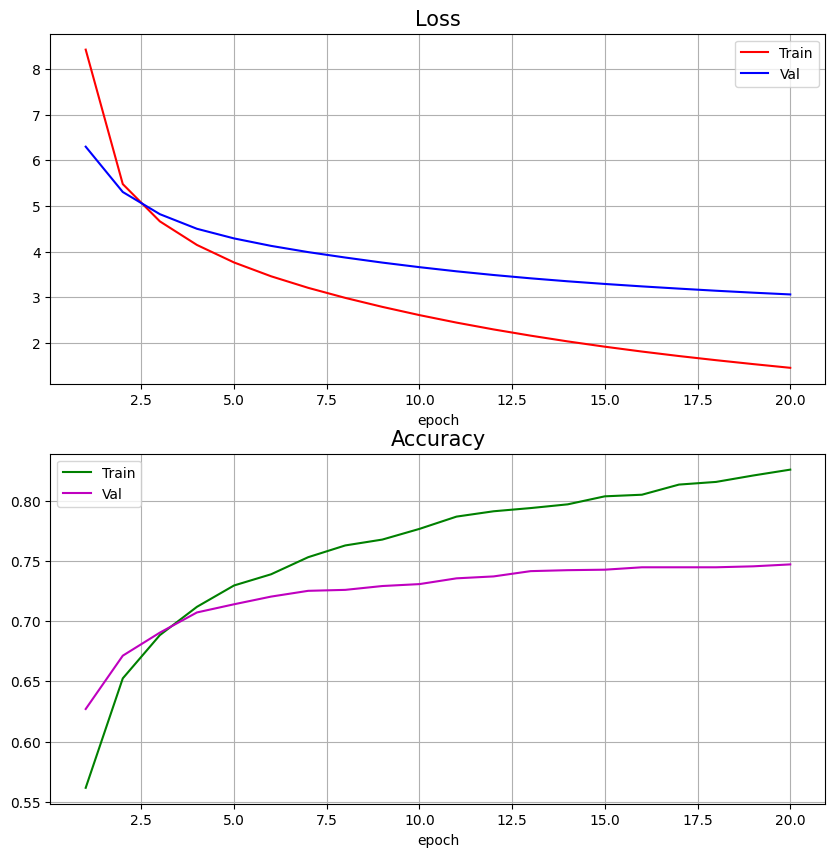

In [ ]:
train_loss=hist.history['loss']
val_loss=hist.history['val_loss']
train_acc=hist.history['Accuracy']
val_acc=hist.history['val_Accuracy']
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

# **Implementing models for weak and strong augmentations**

In [ ]:
Rand_Augment_Weak=tf.keras.Sequential([tf.keras.layers.Input(shape=(img_size,img_size,3)),
                                       keras_cv.layers.RandAugment(value_range=(0,255),magnitude=0.1)])
Rand_Augment_Strong=tf.keras.Sequential([tf.keras.layers.Input(shape=(img_size,img_size,3)),
                                         keras_cv.layers.RandAugment(value_range=(0,255),magnitude=0.5)])

# **Comparing augmentations**

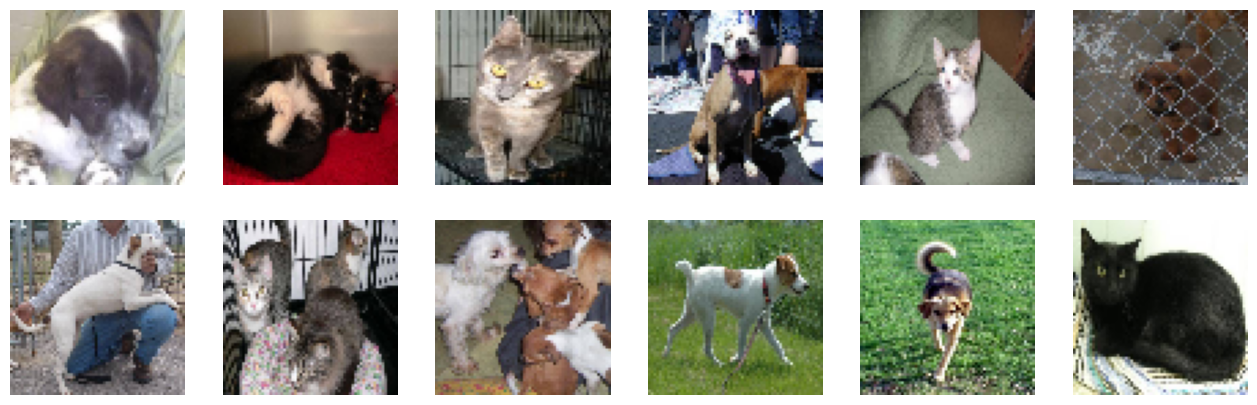

In [ ]:
fig = plt.figure(figsize=(16,5))
for i in range(12):
    ax=fig.add_subplot(2,6,i+1)
    ax.axis('off')
    ax.imshow(X_train_u[i].astype('int'))
plt.show()

In [ ]:
weak_augmented=Rand_Augment_Weak.predict(X_train_u)

165/165 [==============================] - 22s 116ms/step


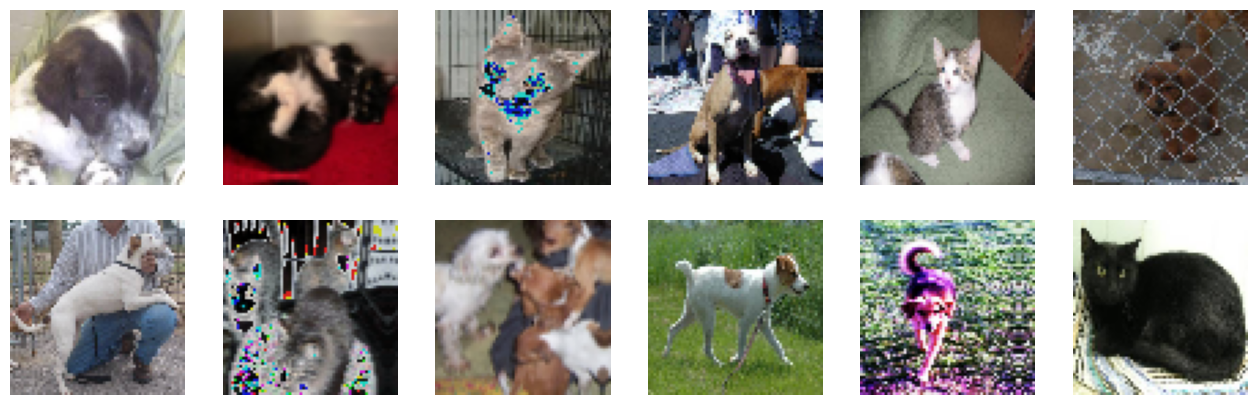

In [ ]:
fig = plt.figure(figsize=(16,5))
for i in range(12):
    ax=fig.add_subplot(2,6,i+1)
    ax.axis('off')
    aug_img=weak_augmented[i]
    ax.imshow(aug_img.astype('int'))
plt.show()

In [ ]:
strong_augmented=Rand_Augment_Strong.predict(X_train_u)

165/165 [==============================] - 22s 112ms/step


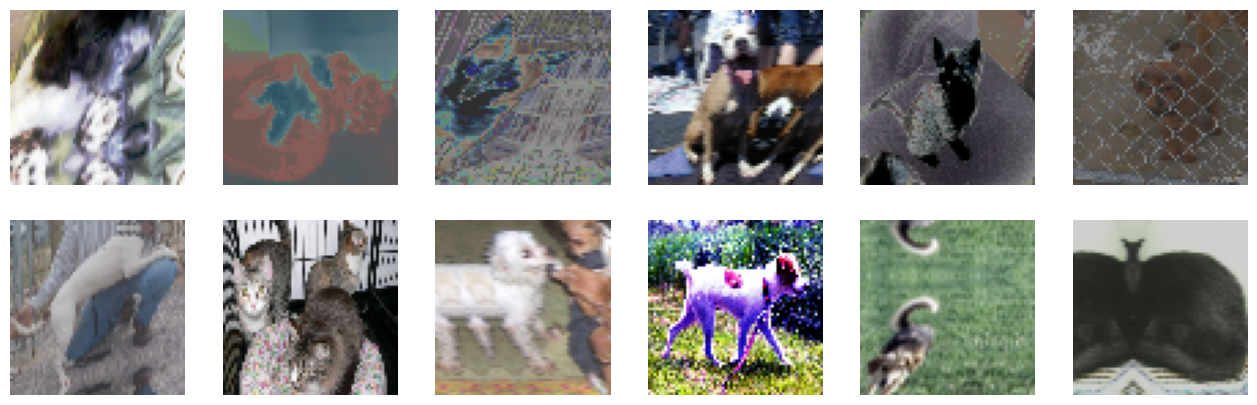

In [ ]:
fig = plt.figure(figsize=(16,5))
for i in range(12):
    ax=fig.add_subplot(2,6,i+1)
    ax.axis('off')
    aug_img=strong_augmented[i]
    ax.imshow(aug_img.astype('int'))
plt.show()

# **Training model, using FixMatch algorithm**

In [ ]:
base_model=tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False,input_shape=(img_size,img_size,3))
for layers in base_model.layers:
    layers.trainable=False
model=tf.keras.Sequential([base_model,
                           tf.keras.layers.Flatten(),
                           tf.keras.layers.Dense(units=2,activation='softmax')])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 20028482 (76.40 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [ ]:
def train_step(labeled_images,labels,unlabeled_images,tau,lmbd,optimizer,val_images,val_labels):
    weak_augmented_l=Rand_Augment_Weak.predict(labeled_images)
    with tf.GradientTape() as tape:
        labeled_pred=model(weak_augmented_l)
        labeled_loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(labels,labeled_pred)
        weak_augmented=Rand_Augment_Weak.predict(unlabeled_images)
        pseudo_labels=model(weak_augmented)
        k=0
        X_=np.zeros(shape=(unlabeled_images.shape[0],img_size,img_size,3),dtype='uint8')
        y_=np.zeros(shape=(unlabeled_images.shape[0]),dtype='uint8')
        strong_augmented=Rand_Augment_Strong.predict(unlabeled_images)
        for i in range(len(pseudo_labels)):
            if np.max(pseudo_labels[i])>tau:
                X_[k]=strong_augmented[i]
                y_[k]=np.argmax(pseudo_labels[i])
                k+=1
        X_=X_[:k]
        y_=y_[:k]
        unlabeled_pred=model(X_)
        unlabeled_loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_,unlabeled_pred)
        total_loss=labeled_loss+lmbd*unlabeled_loss
    gradient=tape.gradient(total_loss,model.trainable_variables)
    optimizer.apply_gradients(zip(gradient,model.trainable_variables))
    loss_metric.update_state(total_loss)
    accuracy=tf.keras.metrics.Accuracy()
    accuracy.update_state(y_true=np.concatenate([labels,y_],axis=0),y_pred=np.concatenate([np.argmax(labeled_pred,axis=1),np.argmax(unlabeled_pred,axis=1)],axis=0))
    accuracy_metric.update_state(accuracy.result())
    accuracy.reset_state()
    val_pred=model(val_images)
    val_loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(val_labels,val_pred)
    val_loss_metric.update_state(val_loss)
    val_accuracy=tf.keras.metrics.Accuracy()
    val_accuracy.update_state(y_true=val_labels,y_pred=np.argmax(val_pred,axis=1))
    val_accuracy_metric.update_state(val_accuracy.result())
    val_accuracy.reset_state()
    return loss_metric.result(),val_loss_metric.result(),accuracy_metric.result(),val_accuracy_metric.result()

In [ ]:
train_loss=[]
val_loss=[]
train_acc=[]
val_acc=[]
EPOCHS=20
BATCH_SIZE_L=64
BATCH_SIZE_U=int(BATCH_SIZE_L*(X_train_u.shape[0]/X_train_l.shape[0]))
if X_train_l.shape[0]%BATCH_SIZE_L==0:
    N_BATCHES_L=X_train_l.shape[0]//BATCH_SIZE_L
else:
    N_BATCHES_L=X_train_l.shape[0]//BATCH_SIZE_L+1
if X_train_u.shape[0]%BATCH_SIZE_U==0:
    N_BATCHES_U=X_train_u.shape[0]//BATCH_SIZE_U
else:
    N_BATCHES_U=X_train_u.shape[0]//BATCH_SIZE_U+1
if N_BATCHES_L!=N_BATCHES_U:
    N_BATCHES_L,N_BATCHES_U=max(N_BATCHES_L,N_BATCHES_U),max(N_BATCHES_L,N_BATCHES_U)
labeled_batches=np.array_split(X_train_l,N_BATCHES_L)
labels_batches=np.array_split(y_train_l,N_BATCHES_L)
unlabeled_batches=np.array_split(X_train_u,N_BATCHES_U)
for i in range(EPOCHS):
    loss_metric=tf.keras.metrics.Mean()
    val_loss_metric=tf.keras.metrics.Mean()
    accuracy_metric=tf.keras.metrics.Mean()
    val_accuracy_metric=tf.keras.metrics.Mean()
    print(f'Epoch {i+1}:')
    for j in range(len(labeled_batches)):
            ind1=np.array([i for i in range(len(labeled_batches))])
            np.random.shuffle(ind1)
            ind2=np.array([i for i in range(len(unlabeled_batches))])
            np.random.shuffle(ind2)
            loss,val_loss_,accuracy,val_accuracy=train_step(labeled_batches[ind1[j]],labels_batches[ind1[j]],unlabeled_batches[ind2[j]],0.99,1,tf.keras.optimizers.Adamax(learning_rate=3e-4),X_val,y_val)
            if j==len(labeled_batches)-1:
                print(f'loss={loss}, val_loss={val_loss_}, accuracy={accuracy}, val_accuracy={val_accuracy}')
                train_loss.append(loss)
                train_acc.append(accuracy)
                val_loss.append(val_loss_)
                val_acc.append(val_accuracy)

Epoch 1:
5/5 [==============================] - 1s 117ms/step
loss=11.90829849243164, val_loss=6.157705307006836, accuracy=0.6450958251953125, val_accuracy=0.6510658860206604
Epoch 2:
5/5 [==============================] - 1s 124ms/step
loss=9.010472297668457, val_loss=4.362615585327148, accuracy=0.6727194786071777, val_accuracy=0.7125049829483032
Epoch 3:
5/5 [==============================] - 1s 110ms/step
loss=7.51768684387207, val_loss=3.77410888671875, accuracy=0.6946628093719482, val_accuracy=0.7317512035369873
Epoch 4:
5/5 [==============================] - 1s 132ms/step
loss=6.792717456817627, val_loss=3.445895195007324, accuracy=0.7132436037063599, val_accuracy=0.742820143699646
Epoch 5:
5/5 [==============================] - 1s 123ms/step
loss=6.601630210876465, val_loss=3.2153666019439697, accuracy=0.7032915353775024, val_accuracy=0.7468754649162292
Epoch 6:
5/5 [==============================] - 1s 117ms/step
loss=6.05782413482666, val_loss=3.029681444168091, accuracy=0.709

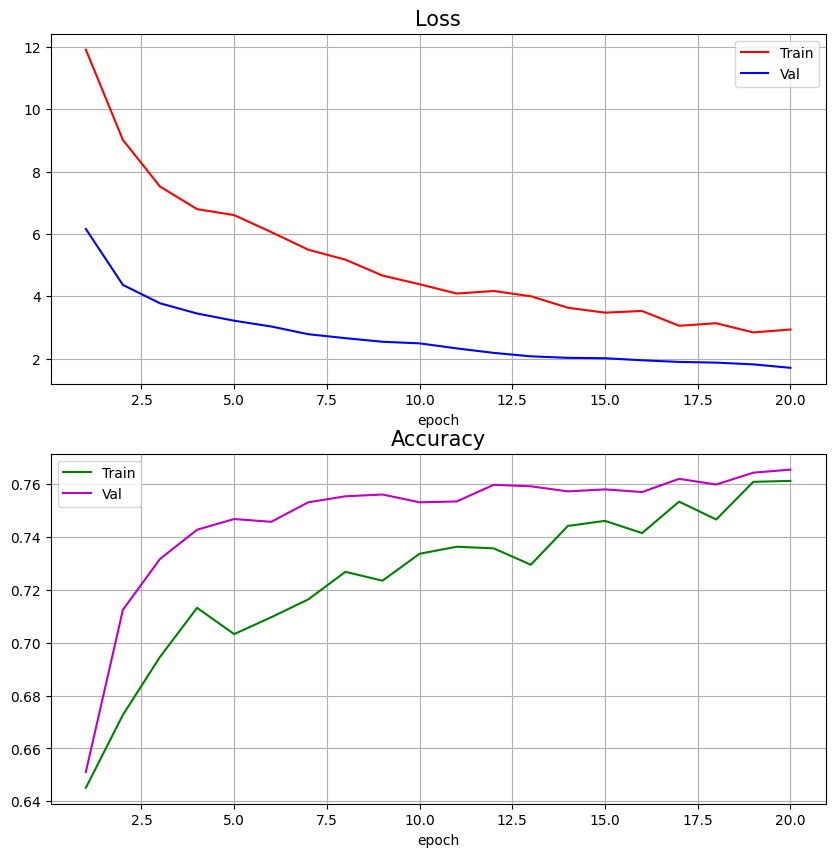

In [ ]:
epochs=[i for i in range(1,len(val_loss)+1)]
fig=plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,1,1)
ax1.set_title('Loss',fontsize=15)
ax1.plot(epochs,train_loss,color='r',label='Train')
ax1.plot(epochs,val_loss,color='b',label='Val')
ax1.set_xlabel('epoch')
ax1.grid()
ax1.legend()
ax2=fig.add_subplot(2,1,2)
ax2.set_title('Accuracy',fontsize=15)
ax2.plot(epochs,train_acc,color='g',label='Train')
ax2.plot(epochs,val_acc,color='m',label='Val')
ax2.set_xlabel('epoch')
ax2.grid()
ax2.legend()
plt.show()

In [ ]:
model.save_weights('/kaggle/working/weights_2.h5')